In [1]:
import time
import timeit
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

%load_ext line_profiler

# setting up initial conditions: 512 1-dimention array
array_len = 512

### Firstly, let's solve 1D and 2D diffusion equations with built-in python code without using libraries.

In [2]:
def evolve_1d(arr, dt, D=1.0):
    xmax = array_len
    new_arr = [0.0 for x in range(xmax)]
    
    for i in range(xmax):
        grid_x = arr[(i+1)%xmax] + arr[(i-1)%xmax] - 2 * arr[i]
        new_arr[i] = arr[i] + D * grid_x * dt
        
    return new_arr

In [3]:
def visualize(u, idx):
    fig = plt.figure()
    ax = fig.add_subplot(111, title='1D Diffusion of a square function' , xlabel='Position', ylabel='t={}'.format(idx), ylim=(0.0, 1.0))
    ax.plot(range(array_len), u)

In [4]:
def run_experiment_1d(num_iterations):
    # setting up initial conditions: 512 1-dimention array
    xmax = array_len
    u = [0.0 for x in range(xmax)]
    block_low = int(array_len * .4)
    block_high = int(array_len * .6)

    for i in range(block_low, block_high):
        u[i] = 0.9
        
    # evolove the initial condition
    start_time = time.time()
    for i in range(num_iterations):
        u = evolve_1d(u, 0.1)
    
        if i == 0 or i == 500 or i == 2500 or i == 10500:
            visualize(u, i)
        
    return time.time() - start_time

2.198369026184082

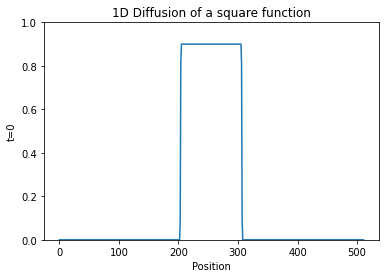

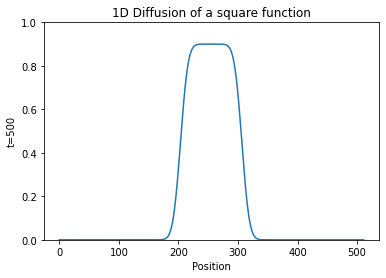

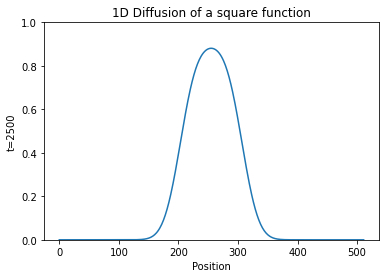

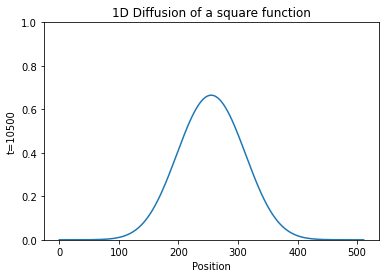

In [5]:
run_experiment_1d(12000)

### Aren’t Python Lists Good Enough?

In [6]:
grid_shape = (1024, 1024)

#### Example 6-3. Pure Python 2D diffusion

In [7]:
def evolve(grid, dt, D=1.0):
    xmax, ymax = grid_shape
    new_grid = [[0.0,] * ymax for x in range(xmax)]
    
    for i in range(xmax):
        for j in range(ymax):
            grid_xx = grid[(i+1)%xmax][j] + grid[(i-1)%xmax][j] - 2.0 * grid[i][j]
            grid_yy = grid[i][(j+1)%ymax] + grid[i][(j-1)%ymax] - 2.0 * grid[i][j]
            new_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt
            
    return new_grid

#### Example 6-4. Pure Python 2D diffusion initialization

In [8]:
def run_experiment(num_iterations):
    # setting up initial conditions: 1024 * 1024 2-dimention array
    xmax, ymax = grid_shape
    grid = [[0.0,] * ymax for x in range(xmax)]
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .6)
    
    for i in range(block_low, block_high):
        for j in range(block_low, block_high):
            grid[i][j] = 0.5
            
    # evolove the initial condition
    start_time = time.time()
    
    counters = []
    images = []
    
    for i in tqdm(range(num_iterations)):
        grid = evolve(grid, 0.1)
        
        if i == 0 or i == 50 or i == 250 or i == 500:
            img_array = np.asarray(grid)
            im = Image.fromarray(img_array * 255)
            counters.append(i)
            images.append(im)
    
    depict_figures(images, counters)
    return time.time() - start_time

def depict_figures(images, counters):
    fig = plt.figure(figsize=(15,8))
    axes=[]
    
    for i in range(len(counters)):
        axes.append( fig.add_subplot(1, 4, i+1) )
        subplot_title=(str(counters[i]) + ' iteration')
        axes[-1].set_title(subplot_title)  
        plt.imshow(images[i])

100%|██████████| 512/512 [06:16<00:00,  1.36it/s]


377.06765723228455

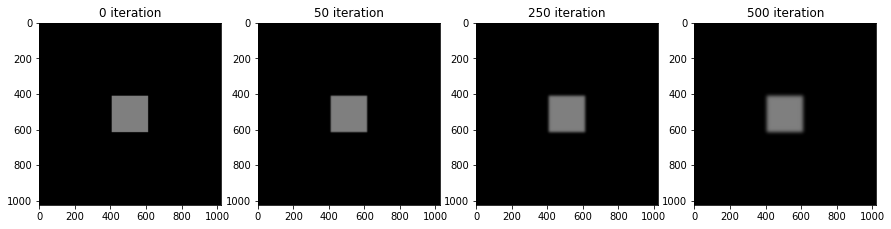

In [9]:
run_experiment(512)

### Let's check the bottleneck in the code with line profiler.

In [10]:
xmax, ymax = grid_shape
grid = [[0.0,] * ymax for x in range(xmax)]
%lprun -f evolve evolve(grid, 0.1)

### Optimization is so important!! Take the following code for example.

In [11]:
from math import sin

def loop_slow(num_iterations):
    result = 0
    for i in range(num_iterations):
        result += i * sin(num_iterations)
    return result

def loop_fast(num_iterations):
    result = 0
    factor = sin(num_iterations)
    for i in range(num_iterations):
        result += i
    return result * factor

In [12]:
%timeit loop_slow(int(1e4))

1.19 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit loop_fast(int(1e4))

439 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Result
Processing time varies greatly depending on the processing method.

### Enter numpy

In [14]:
from array import array
import numpy

def norm_square_list(vector):
    norm = 0
    for v in vector:
        norm += v *v
    return norm

def norm_square_list_comprehension(vector):
    return sum([v * v for v in vector])

def norm_square_generator_comprehension(vector):
    return sum(v * v for v in vector)

def norm_square_array(vector):
    norm = 0
    for v in vector:
        norm += v *v
    return norm

def norm_square_numpy(vector):
    return numpy.sum(vector * vector)

def norm_square_numpy_dot(vector):
    return numpy.dot(vector, vector)

In [15]:
vector_list = range(1000000)
vector_array = array('l', range(1000000))
vector_numpy = numpy.arange(1000000)

In [16]:
%timeit norm_square_list(vector_list)

84.6 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit norm_square_list_comprehension(vector_list)

77.4 ms ± 881 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit norm_square_generator_comprehension(vector_list)

75.1 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit norm_square_array(vector_array)

88.2 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit norm_square_numpy(vector_numpy)

2.7 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit norm_square_numpy_dot(vector_numpy)

606 µs ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Result
The ways of doing vector norms in numpy are much faster than that of built-in list or array in python.

<hr>

#### Problem
How effective is the use of numpy when the length of the array to be stored is increased?

In [22]:
repeat_num = 10
arrays_length = [62500, 125000, 250000, 500000, 1000000, 2000000, 4000000, 8000000]

In [23]:
vector_lists = [range(arrays_length[i]) for i in range(len(arrays_length))]

norm_square_list_results = []
norm_square_list_label = 'norm_square_list'

for v_list in vector_lists:
    t = timeit.timeit('norm_square_list(v_list)', globals=globals(), number=repeat_num)
    norm_square_list_results.append(t/repeat_num * 1000)

In [24]:
vector_numpys = [numpy.arange(arrays_length[i]) for i in range(len(arrays_length))]

norm_square_numpy_dot_results = []
norm_square_numpy_dot_label = 'norm_square_numpy_dot'

for v_numpy in vector_numpys:
    t = timeit.timeit('norm_square_numpy_dot(v_numpy)', globals=globals(), number=repeat_num)
    norm_square_numpy_dot_results.append(t/repeat_num * 1000)

In [25]:
norm_square_numpy_results = []
norm_square_numpy_label = 'norm_square_numpy'

for v_numpy in vector_numpys:
    t = timeit.timeit('norm_square_numpy(v_numpy)', globals=globals(), number=repeat_num)
    norm_square_numpy_results.append(t/repeat_num * 1000)

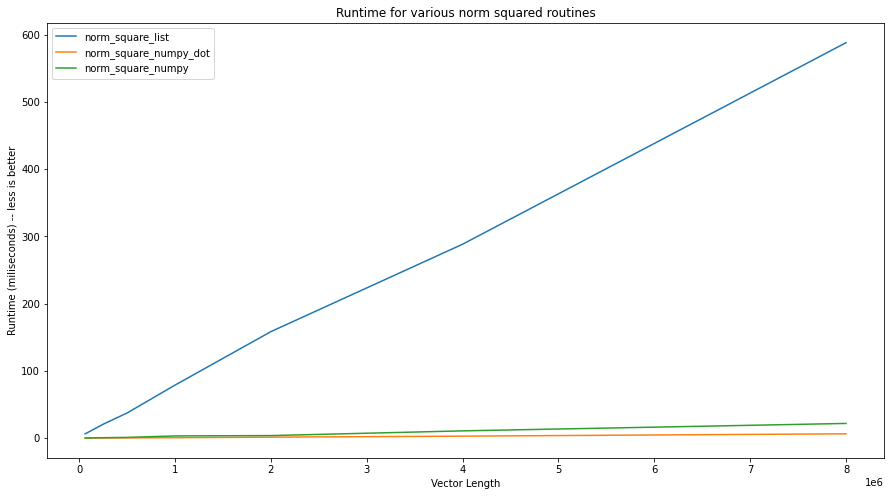

In [26]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, title='Runtime for various norm squared routines' , xlabel='Vector Length', ylabel='Runtime (miliseconds) -- less is better')
ax.plot(arrays_length, norm_square_list_results, label=norm_square_list_label)
ax.plot(arrays_length, norm_square_numpy_dot_results, label=norm_square_numpy_dot_label)
ax.plot(arrays_length, norm_square_numpy_results, label=norm_square_numpy_label)
ax.legend(loc=0)

## Applying numpy to the Diffusion Problem

The comments in the following codes are pure Python codes.

#### Example 6-9. Initial numpy diffusion

In [27]:
grid_shape = (1024, 1024)

def laplacian(grid):
#     for i in range(xmax):
#         for j in range(ymax):
#             grid_xx = grid[(i+1)%xmax][j] + grid[(i-1)%xmax][j] - 2.0 * grid[i][j]
#             grid_yy = grid[i][(j+1)%ymax] + grid[i][(j-1)%ymax] - 2.0 * grid[i][j]
#             new_grid[i][j] = grid[i][j] + (grid_xx + grid_yy) 
    return np.roll(grid, +1, 0) + np.roll(grid, -1, 0) + np.roll(grid, +1, 1) + np.roll(grid, -1, 1) - 4 * grid

def evolve(grid, dt, D=1):
    return grid + dt * D * laplacian(grid)

def run_experiment(num_iterations):
    # setting up initial conditions: 1024 * 1024 2-dimention array
    grid = np.zeros(grid_shape)
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    
#     for i in range(block_low, block_high):
#         for j in range(block_low, block_high):
#             grid[i][j] = 0.005
    grid[block_low:block_high, block_low:block_high] = 0.005
            
    # evolove the initial condition
    start_time = time.time()
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)

    return time.time() - start_time

In [28]:
run_experiment(512)

9.235948085784912

#### Result
In comaprison with pure Python code(Example. 6-4), the processing speed is about x50.

### Memory Allocations and In-Place Operations

#### Example 6-12. In-place operations reducing memory allocations

In [29]:
array1 = np.random.random((10,10))
array2 = np.random.random((10,10))

print(id(array1))
array1 += array2
print(id(array1))
array1 = array1 + array2
print(id(array1))

4966298288
4966298288
4967585072


#### Example 6-13. In-place operations reducing memory allocations

In [30]:
 %timeit array1, array2 = np.random.random((10,10)), np.random.random((10,10)); array1 = array1 + array2

3.79 µs ± 237 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [31]:
 %timeit array1, array2 = np.random.random((10,10)), np.random.random((10,10)); array1 += array2

4.53 µs ± 164 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


#### Result
The former takes more time because a new memory address is allocated.

#### Example 6-14. Making most numpy operations in-place

In [32]:
def laplacian(grid, out):
#     return np.roll(grid, +1, 0) + np.roll(grid, -1, 0) + np.roll(grid, +1, 1) + np.roll(grid, -1, 1) - 4 * grid
    out *= -4
    out += np.roll(grid, +1, 0)
    out += np.roll(grid, -1, 0)
    out += np.roll(grid, +1, 1)
    out += np.roll(grid, -1, 1)

def evolve(grid, dt, out, D=1):
#     return grid + dt * D * laplacian(grid)
    laplacian(grid, out)
    out *= dt * D
    out += grid

def run_experiment(num_iterations):
    # setting up initial conditions: 1024 * 1024 2-dimention array
    grid = np.zeros(grid_shape)
    next_grid = np.zeros(grid_shape)
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)    
    grid[block_low:block_high, block_low:block_high] = 0.005

    # evolove the initial condition
    start_time = time.time()
    for i in range(num_iterations):
        evolve(grid, 0.1, next_grid)
        grid, next_grid = next_grid, grid

    return time.time() - start_time

In [33]:
run_experiment(512)

7.356719970703125

#### Result
In comaprison with pure Python code(Example. 6-9), the processing speed has been improved a bit.

### Selective Optimizations: Finding What Needs to Be Fixed

#### Example 6-16. Line profiling shows that laplacian is taking too much time

In [34]:
grid = np.zeros(grid_shape)
next_grid = np.zeros(grid_shape)
%lprun -f evolve evolve(grid, 0.1, next_grid)

In [35]:
%lprun -f laplacian laplacian(grid, next_grid)

#### Problem
Through benchmark, the bottleneck turned out. So next, we think about another approach for improving processing speed.

#### Example 6-17. Creating our own roll function

In [36]:
def roll_add(rollee, shift, axis, out):
    """
    Given a matrix, rollee, and an output matrix, out, this function will
    perform the calculation
    
        >>> out += np.roll(rollee, shift, axis=axis)
    
    This is done with the following assumptions:
        * rollee is 2D
        * shift will only ever be +1 or -1
        * axis will only ever be 0 or 1 (also implied by the first assumption)
        
    Using these assumptions, we are able to speed up this function by avoiding
    extra machinery that numpy uses to generalize the `roll` function and also
    by making this operation intrinsically in-place.
    """
    
    if shift == 1 and axis == 0:
        out[1:, :] += rollee[:-1, :]
        out[0, :] += rollee[-1, :]
    elif shift == -1 and axis == 0:
        out[:-1, :] += rollee[1:, :]
        out[-1, :] += rollee[0, :]
    elif shift == 1 and axis == 1:
        out[:, 1:] += rollee[:, :-1]
        out[:, 0] += rollee[:, -1]
    elif shift == -1 and axis == 1:
        out[:, :-1] += rollee[:, 1:]
        out[: , -1] += rollee[:, 0]
        
def laplacian(grid, out):
    np.copyto(out, grid)
    out *= -4
    roll_add(grid, +1, 0, out)
    roll_add(grid, -1, 0, out)
    roll_add(grid, +1, 1, out)
    roll_add(grid, -1, 1, out)

In [37]:
run_experiment(512)

3.7018589973449707

#### Result
The processing speed has been improved by rewriting laplacian function.

### numexpr: Making In-Place Operations Faster and Easier

#### Example 6-19. Using numexpr to further optimize large matrix operations

In [38]:
from numexpr import evaluate

def evolve(grid, dt, next_grid, D=1):
#     return grid + dt * D * laplacian(grid)
    laplacian(grid, next_grid)
    evaluate("next_grid*D*dt+grid", out=next_grid)

In [39]:
run_experiment(512)

3.69588303565979

### A Cautionary Tale: Verify “Optimizations” (scipy)

In [40]:
from scipy.ndimage.filters import laplace

def laplacian(grid, out):
    laplace(grid, out, mode='wrap')

In [41]:
run_experiment(512)

7.931859254837036

#### Result
Using scipy for the Laplacian function made the results worse.